Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# CV01 Classification

### Lab Description

This laboratory exercise introduces a **custom Convolutional Neural Network (CNN)** designed for the `CIFAR-100` dataset.  
Unlike pre-trained networks (e.g., ResNet), this CNN is built from scratch to highlight the role of convolution, pooling, normalization, dropout, and fully connected layers in image classification tasks.

The architecture consists of multiple convolutional blocks with increasing feature channels, dropout regularization, and a fully connected classifier head.

### What you can expect to learn

- **Theoretical Understanding**:  
  - Understand how CNNs extract spatial hierarchies of features.  
  - Explore the effect of dropout and batch normalization on generalization and training stability.  

- **Implementation of CNN**:  
  - Build and train a CNN from scratch using PyTorch.  
  - Adapt the classifier for 100 classes in `CIFAR-100`.  

- **Training & Monitoring**:  
  - Track per-epoch training time, batch size, and VRAM usage.  
  - Monitor training and validation loss/accuracy over time.  

- **Visualization & Evaluation**:  
  - Plot learning curves to confirm that the network is converging.  
  - Evaluate model accuracy on the test set.  
  - Save logs (CSV) with runtime and resource usage statistics.  

In [ ]:
import sys

import torch
import torchvision

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

## 1. Import necessary libraries

In [1]:
import os
import random
import time
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR100

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

if device == "cuda":
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device: cuda
GPU 0: AMD Radeon AI PRO R9700


## 2. Configuration and Setup

In this section, we define a configuration dataclass (`CFG`) that stores all important hyperparameters such as batch size, number of epochs, learning rate, and image size.  
We also implement a `set_seed` function to ensure reproducibility of results by fixing random seeds for Python, NumPy, and PyTorch.  

Finally, we create local directories for dataset storage (`~/data`) and experiment outputs (`~/output/cnn_cifar100`).


In [3]:
@dataclass
class CFG:
    seed: int = 42
    batch_size: int = 128
    epochs: int = 60
    lr: float = 1e-3
    img_size: int = 32
    num_classes: int = 100
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


cfg = CFG()


# 📌 Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(cfg.seed)

# Paths
DATA_DIR = os.path.expanduser("~/data")
OUTPUT_DIR = os.path.expanduser("~/output/cnn_cifar100")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Required Dataset

We use the `CIFAR-100` dataset, which contains 60,000 color images (32×32 pixels) divided into 100 classes, each with 600 images.  
The dataset is split into 50,000 training images and 10,000 test images. For validation, we further split 5,000 images from the training set.


In [4]:
# 📂 Dataset & Dataloaders

CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)

train_tfms = T.Compose(
    [
        T.RandomCrop(cfg.img_size, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
    ]
)

test_tfms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
    ]
)

# Load dataset
train_set = CIFAR100(root=DATA_DIR, train=True, download=True, transform=train_tfms)
test_set = CIFAR100(root=DATA_DIR, train=False, download=True, transform=test_tfms)

# Split validation from training
val_size = 5000
train_size = len(train_set) - val_size
train_set, val_set = random_split(train_set, [train_size, val_size], generator=torch.Generator().manual_seed(cfg.seed))

train_loader = DataLoader(
    train_set, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    val_set, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available()
)
test_loader = DataLoader(
    test_set, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available()
)

len(train_set), len(val_set), len(test_set)

(45000, 5000, 10000)

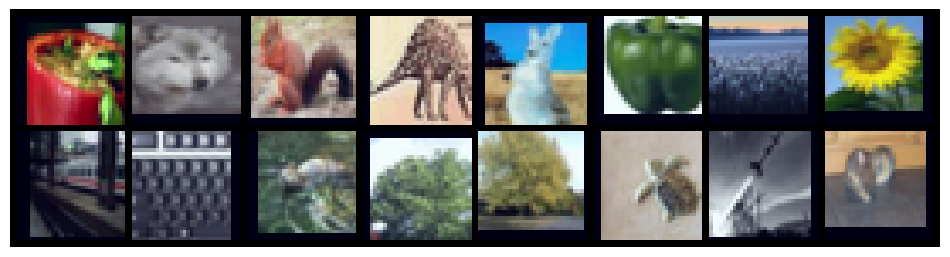

Labels: ['sweet_pepper', 'wolf', 'squirrel', 'dinosaur', 'kangaroo', 'sweet_pepper', 'plain', 'sunflower', 'train', 'keyboard', 'otter', 'maple_tree', 'maple_tree', 'turtle', 'rocket', 'rabbit']


In [5]:
classes = train_set.dataset.classes


def show_batch(dl):
    imgs, labels = next(iter(dl))
    grid = torchvision.utils.make_grid(imgs[:16], nrow=8, normalize=True)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.show()
    print("Labels:", [classes[l] for l in labels[:16]])


show_batch(train_loader)

## 4. Model Architecture

We implement a **Convolutional Neural Network (CNN)** for `CIFAR-100` classification, named `BasicCNN`.  
The architecture is designed to progressively extract higher-level features through convolutional blocks, followed by a fully connected classifier.

In [6]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=100, p_drop_conv=0.3, p_drop_fc=0.5, negative_slope=0.1):
        super().__init__()
        act = lambda: nn.LeakyReLU(negative_slope=negative_slope, inplace=True)

        self.features = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            act(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            act(),
            nn.MaxPool2d(2),
            nn.Dropout(p_drop_conv),
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            act(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            act(),
            nn.MaxPool2d(2),
            nn.Dropout(p_drop_conv),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            act(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            act(),
            nn.MaxPool2d(2),
            nn.Dropout(p_drop_conv),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            act(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            act(),
            nn.MaxPool2d(2),
            nn.Dropout(p_drop_conv),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 1024, bias=False),
            nn.LeakyReLU(negative_slope=negative_slope, inplace=True),
            nn.Dropout(p_drop_fc),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))


model = BasicCNN(num_classes=cfg.num_classes).to(cfg.device)

## 5. Training Loop

We train the CNN on `CIFAR-100` using the **Adam optimizer** and **cross-entropy loss**.

In [ ]:
import os
import sys
from pathlib import Path

import pandas as pd
import torch
import torch.nn as nn

log_path = Path.home() / "data/cnn_ckpt_cifar100" / "log.txt"
log_path.parent.mkdir(parents=True, exist_ok=True)
f = open(log_path, "a", buffering=1)  # line-buffered
sys.stdout = sys.stderr = f
print(f"[info] Logging to {log_path}")

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)


def reset_peak():
    torch.cuda.reset_peak_memory_stats(device)


def get_vram_mb():
    return torch.cuda.max_memory_allocated(device) / (1024**2)


history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "epoch_time": [],
    "vram": [],
    "batch_size": cfg.batch_size,
}

for epoch in range(cfg.epochs):
    torch.cuda.synchronize(device)
    t0 = time.time()

    model.train()
    train_loss, correct, total = 0.0, 0, 0
    reset_peak()

    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        bs = imgs.size(0)
        train_loss += loss.item() * bs
        _, pred = out.max(1)
        correct += pred.eq(labels).sum().item()
        total += bs

    train_loss /= max(1, total)
    train_acc = correct / max(1, total)

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            out = model(imgs)
            loss = criterion(out, labels)
            bs = imgs.size(0)
            val_loss += loss.item() * bs
            _, pred = out.max(1)
            val_correct += pred.eq(labels).sum().item()
            val_total += bs

    val_loss /= max(1, val_total)
    val_acc = val_correct / max(1, val_total)

    torch.cuda.synchronize(device)
    epoch_time = time.time() - t0
    peak_vram = get_vram_mb()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["epoch_time"].append(epoch_time)
    history["vram"].append(peak_vram)

    print(
        f"Epoch {epoch + 1}/{cfg.epochs} | "
        f"Train Loss {train_loss:.3f}, Acc {train_acc:.3f} | "
        f"Val Loss {val_loss:.3f}, Acc {val_acc:.3f} | "
        f"Time {epoch_time:.2f}s | VRAM {peak_vram:.1f} MB"
    )

# ---- Save log ----
os.makedirs(OUTPUT_DIR, exist_ok=True)
pd.DataFrame(history).to_csv(os.path.join(OUTPUT_DIR, "log.csv"), index=False)

In [ ]:
# Plot curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

save_dir = log_path.parent
save_dir.mkdir(parents=True, exist_ok=True)
fig_path = save_dir / "cifar100_training_curves.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"[info] Save Loss Curve: {fig_path}")

## 6. Evaluation

After training and validation, we evaluate the trained CNN on the `CIFAR-100` test set.  


In [ ]:
# Final Evaluation on Test Set
model.eval()
test_loss, test_correct, test_total = 0, 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(cfg.device), labels.to(cfg.device)
        out = model(imgs)
        loss = criterion(out, labels)

        test_loss += loss.item() * imgs.size(0)
        _, pred = out.max(1)
        test_correct += pred.eq(labels).sum().item()
        test_total += labels.size(0)

test_loss /= test_total
test_acc = test_correct / test_total

print(f"Accuracy {test_acc:.3f}")

# Close log.txt
f.close()
sys.stdout = sys.__stdout__
sys.stderr = sys.__stderr__
print("[info] training + eval log saved:", log_path)